In [1]:
# Install required packages

!pip install transformers torch pillow scikit-learn matplotlib -q
!pip install hf_transfer

  Using cached hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
Using cached hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


In [2]:
import sys
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.classification import load_clip_model

# directories
# We use Train and Valid for the "Memory Bank" (Visual Anchors)
# We use Test for the Confusion Matrix
DATASET_ROOT = "../data/roboflow_refrescos"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VALID_DIR = os.path.join(DATASET_ROOT, "valid")
TEST_DIR = os.path.join(DATASET_ROOT, "test")
WEIGHTS_DIR = "../weights"

os.makedirs(WEIGHTS_DIR, exist_ok=True)

In [3]:
splits = {
    "TRAIN": TRAIN_DIR,
    "VALID": VALID_DIR,
    "TEST": TEST_DIR
}

for split_name, split_path in splits.items():
    print(f"\n--- {split_name} SET ({split_path}) ---")
    if os.path.exists(split_path):
        total_images = 0
        # Get list of class folders
        classes = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
        
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            # Count only files (ignore hidden subdirs like .ipynb_checkpoints)
            count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
            print(f"  {cls:<20}: {count} images")
            total_images += count
            
        print(f"  {'TOTAL':<20}: {total_images} images")
    else:
        print(f"  Path does not exist!")


--- TRAIN SET (../data/roboflow_refrescos/train) ---
  7 Up                : 456 images
  Coca-cola           : 307 images
  Fanta               : 317 images
  Mountain Dew        : 352 images
  Otro                : 444 images
  Pepsi               : 318 images
  Sprite              : 263 images
  TOTAL               : 2457 images

--- VALID SET (../data/roboflow_refrescos/valid) ---
  7 Up                : 50 images
  Coca-cola           : 115 images
  Fanta               : 110 images
  Mountain Dew        : 50 images
  Otro                : 99 images
  Pepsi               : 114 images
  Sprite              : 110 images
  TOTAL               : 648 images

--- TEST SET (../data/roboflow_refrescos/test) ---
  7 Up                : 130 images
  Coca-cola           : 130 images
  Fanta               : 130 images
  Mountain Dew        : 130 images
  Pepsi               : 130 images
  Sprite              : 130 images
  TOTAL               : 780 images


In [4]:
# load clip model
print("Loading CLIP model...")
model, processor = load_clip_model()
device = "cuda" if torch.cuda.is_available() else "cpu"

Loading CLIP model...
Loading CLIP model: openai/clip-vit-base-patch32...


In [5]:
# helper function to get embeddings
def get_image_embedding(image_path, model, processor):
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = model.get_image_features(**inputs)
            # Normalize for cosine similarity
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
        return emb
    except Exception as e:
        return None

In [6]:
# BUILD VISUAL ANCHORS 
# mergin Train + Valid folders
print("Building Visual Anchors from Train and Valid sets...")

ref_features_list = []
ref_labels_list = []

# Merge Train and Valid folders
for subset_dir in [TRAIN_DIR, VALID_DIR]:
    if not os.path.exists(subset_dir):
        continue
        
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # Normalize Label Names
        raw = class_name.lower().strip()

        if "coca" in raw: label = "Coca-Cola"
        elif "pepsi" in raw: label = "Pepsi"
        elif "sprite" in raw: label = "Sprite"
        elif "fanta" in raw: label = "Fanta"
        elif "otro" in raw or "other" in raw: label = "Other"
        elif "7up" in raw or "7 up" in raw: label = "7 Up"
        elif "dew" in raw: label = "Mountain Dew"
        else:
            label = class_name.title()
            
        # Process Images
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.webp')):
                continue
            
            img_path = os.path.join(class_dir, img_name)
            emb = get_image_embedding(img_path, model, processor)
            
            if emb is not None:
                ref_features_list.append(emb)
                ref_labels_list.append(label)

if not ref_features_list:
    raise ValueError("No images found. Check your dataset path.")

# Convert to Tensor Stack
ref_features = torch.cat(ref_features_list, dim=0)
print(f"Anchors Built. Total Reference Images: {len(ref_labels_list)}")
print(f"Classes: {set(ref_labels_list)}")

Building Visual Anchors from Train and Valid sets...
Anchors Built. Total Reference Images: 3105
Classes: {'Fanta', 'Sprite', 'Coca-Cola', 'Pepsi', '7 Up', 'Mountain Dew', 'Other'}


In [7]:
# SAVE ANCHORS
# This file is used by the Streamlit App and Inference Pipeline
anchor_data = {
    "features": ref_features.cpu(),
    "labels": ref_labels_list
}
save_path = os.path.join(WEIGHTS_DIR, "visual_anchors.pkl")
with open(save_path, "wb") as f:
    pickle.dump(anchor_data, f)
print(f"Visual anchors saved to {save_path}")

Visual anchors saved to ../weights/visual_anchors.pkl


Running Evaluation on Test Set...
CLIP Classification Accuracy: 98.97%
Confusion Matrix saved to ../results/clip_classification_confusion_matrix.png


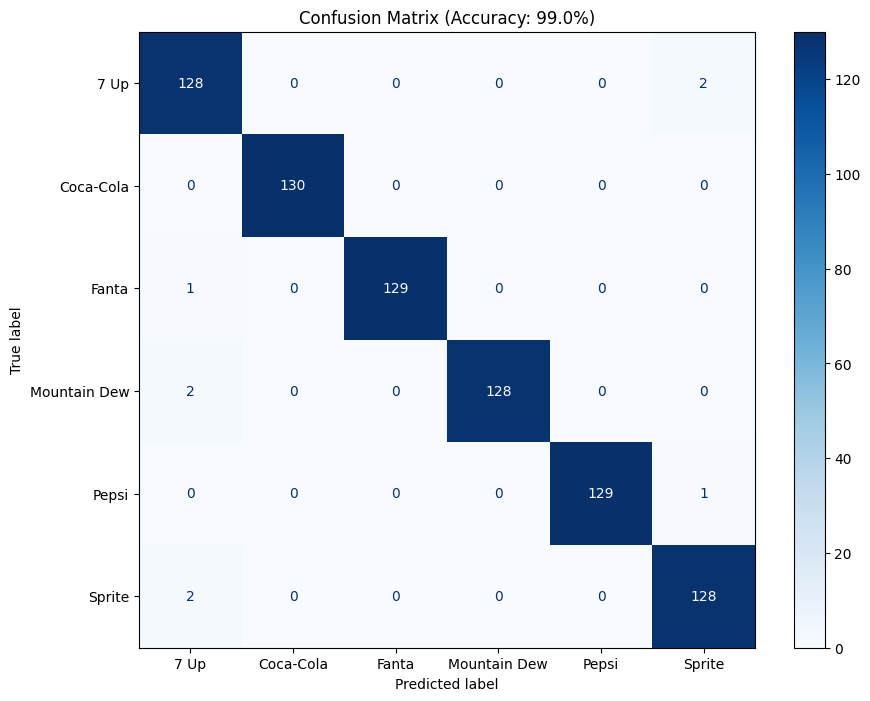

In [8]:
# EVALUATION (Confusion Matrix on Test Set)
print("Running Evaluation on Test Set...")

if not os.path.exists(TEST_DIR):
    print("Test directory not found. Skipping evaluation.")
else:
    y_true = []
    y_pred = []
    
    # Iterate through Test folders
    for class_name in os.listdir(TEST_DIR):
        class_dir = os.path.join(TEST_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # --- ROBUST TRUE LABEL NORMALIZATION (Must match Step 1) ---
        raw = class_name.lower().strip()
        
        if "coca" in raw: true_label = "Coca-Cola"
        elif "pepsi" in raw: true_label = "Pepsi"
        elif "sprite" in raw: true_label = "Sprite"
        elif "fanta" in raw: true_label = "Fanta"
        elif "otro" in raw or "other" in raw: true_label = "Other"
        elif "7up" in raw or "7 up" in raw: true_label = "7 Up"
        elif "dew" in raw: true_label = "Mountain Dew"
        else:
            true_label = class_name.title()
            
        # Predict each image in Test set
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
                
            img_path = os.path.join(class_dir, img_name)
            
            # Get Embedding for Test Image
            test_emb = get_image_embedding(img_path, model, processor)
            if test_emb is None:
                continue
                
            # Compare against Memory Bank (Nearest Neighbor)
            # 1. Dot Product (Cosine Similarity)
            similarities = (test_emb @ ref_features.T).squeeze(0)
            
            # 2. Find Best Match
            best_idx = similarities.argmax().item()
            predicted_label = ref_labels_list[best_idx]
            
            y_true.append(true_label)
            y_pred.append(predicted_label)

    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    print(f"CLIP Classification Accuracy: {acc*100:.2f}%")
    
    # Plot Confusion Matrix
    unique_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap="Blues", ax=ax)
    plt.title(f"Confusion Matrix (Accuracy: {acc*100:.1f}%)")
    
    # Save Matrix Plot
    plt.savefig("../results/clip_classification_confusion_matrix.png")
    print("Confusion Matrix saved to ../results/clip_classification_confusion_matrix.png")

    plt.show()